# Cas13Hunter: Data Preprocessing

This notebook performs preprocessing of raw viral genome sequences to ensure data quality and readiness for downstream analysis.

__Steps:__
1. Load raw viral genome sequences.
2. Perform quality control (e.g., remove duplicates, handle ambiguous bases).
3. Save cleaned and processed sequences.

## 1. Setup

### Import Libraries

In [2]:
import os
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt

### Define Input and Output Paths

In [3]:
RAW_DATA_DIR = "../data/raw/"
PROCESSED_DATA_DIR = "../data/processed/"
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

## 2. Load Raw Viral Genome Sequences

### Load FASTA Files

In [4]:
fasta_file = os.path.join(RAW_DATA_DIR, "sample_viral_sequences.fasta")
sequences = list(SeqIO.parse(fasta_file, "fasta"))

In [5]:
# Display the total number of sequences
print(f"Total sequences loaded: {len(sequences)}")

Total sequences loaded: 500


## 3. Visualise Sequence Statistics

### Sequence Length Distribution

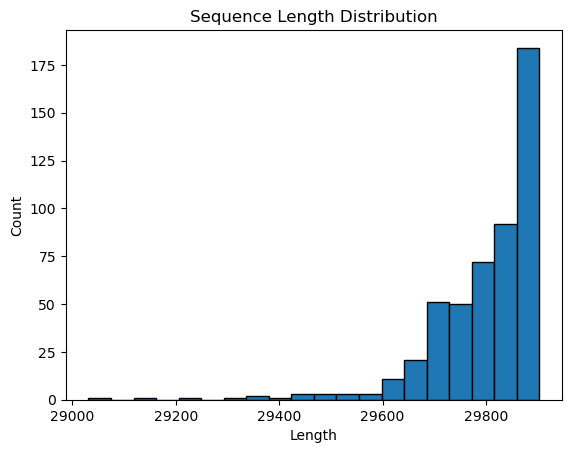

In [6]:
seq_lengths = [len(record.seq) for record in sequences]
plt.hist(seq_lengths, bins=20, edgecolor="black")
plt.title("Sequence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

## 4. Clean and Filter Sequences

### Remove Duplicates

In [7]:
unique_sequences = {str(record.seq): record for record in sequences}
sequences = list(unique_sequences.values())
print(f"Sequences after removing duplicates: {len(sequences)}")

Sequences after removing duplicates: 500


### Filter Sequences by Length

Viral genomes like SARS-CoV-2 may vary slightly in length due to insertions, deletions, or sequencing errors. Tools for conserved region analysis (e.g., MSA) can handle minor length differences. __However, sequences with vastly different lengths may indicate incomplete or erroneous data and should be filtered.__

In [8]:
# Define minimum and maximum length
MIN_LENGTH = 29000
MAX_LENGTH = 30000

# Filter sequences within the specified range
filtered_sequences = [record for record in sequences if MIN_LENGTH <= len(record.seq) <= MAX_LENGTH]
print(f"Sequences after length filtering: {len(filtered_sequences)}")

Sequences after length filtering: 500


### Remove Sequences with High Ambiguity (Soft)

In [9]:
# Define maximum ambiguity threshold (e.g., 5%)
MAX_AMBIGUITY = 0.05

# Remove sequences with more than the threshold percentage of ambiguous bases
filtered_ambiguous = [
    record for record in filtered_sequences
    if str(record.seq).count("N") / len(record.seq) <= MAX_AMBIGUITY
]
print(f"Sequences after removing high-ambiguity sequences: {len(filtered_ambiguous)}")

Sequences after removing high-ambiguity sequences: 454


### Remove Sequences with High Ambiguity (Hard)

In [10]:
# valid_sequences = [record for record in sequences if "N" not in str(record.seq)]
# print(f"Sequences after removing ambiguous bases: {len(valid_sequences)}")

### Replace Ambiguous Bases

In [11]:
# Replace ambiguous bases ('N') with the most common base at each position
def replace_ambiguous(seq, reference):
    # Convert sequence to a mutable list
    seq = list(seq)
    
    # Iterate over the sequence within the bounds of the consensus sequence
    for i, base in enumerate(seq):
        if i < len(reference) and base == "N":  # Ensure we're within the index of the reference
            seq[i] = reference[i]  # Replace 'N' with the most common base
    
    # Convert back to a string and return
    return "".join(seq)

In [12]:
# Example sequences
sequence = "AUGNNNUGGUCU"
consensus_sequence = "AUGUCCUGGUCU"

# Replace ambiguous bases
cleaned_sequence = replace_ambiguous(sequence, consensus_sequence)

print(f"Original sequence:   {sequence}")
print(f"Consensus sequence: {consensus_sequence}")
print(f"Cleaned sequence:    {cleaned_sequence}")

Original sequence:   AUGNNNUGGUCU
Consensus sequence: AUGUCCUGGUCU
Cleaned sequence:    AUGUCCUGGUCU


The length of the sequences in `filtered_ambiguous` may vary, and attempting to iterate over the length of the first sequence (`filtered_ambiguous[0].seq`) could lead to an __index out of range error__. To fix this, we should use the length of the shortest sequence.

In [13]:
from collections import Counter

# Find the length of the smallest sequence
min_length = min(len(record.seq) for record in filtered_ambiguous)

# Generate a consensus sequence up to the length of the smallest sequence
consensus_seq = "".join(
    Counter([str(record.seq)[i] for record in filtered_ambiguous]).most_common(1)[0][0]
    for i in range(min_length)
)

print(f"Consensus sequence (length {len(consensus_seq)}):")
print(consensus_seq)

Consensus sequence (length 29247):
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNANNNNNNNTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTACTGTCGTTGACAGGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGGAGGAGGTCTTATCAGAGGCACGTCAACATCTTAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAAGGCGTTTTGCCTCAACTTGAACAGCCCTATGTGTTCATCAAACGTTCGGATGCTCGAACTGCACCTCATGGTCATGTTATGGTTGAGCTGGTAGCAGAACTCGAAGGCATTCAGTACGGTCGTAGTGGTGAGACACTTGGTGTCCTTGTCCCTCATGTGGGCGAAATACCAGTGGCTTACCGCAAGGTTCTTCTTCGTAAGAACGGTAATAAAGGAGCTGGTGGCCATAGTTACGGCGCCGATCTAAAGTCATTTGACTTAGGCGACGAGCTTGGCACTGATCCTTATGAAGATTTTCAAGAAAACTGGAACACTAAACATAGCAGTGGTGTTACCCGTGAACTCATGCGTGAGCTTAACGGAGGGGCATACACTCGCTATGTCGATAACAACTTCTGTGGCCCTGATGGCTACCCTCTTGAGTGCATTAAAGACCTTCTAGCACGTGCTGGTAAAGCTTCATGCACTTTGTCCGAACAACTGGACTTTATTGACACTAAGAGGGGTGTATACTGCTGCCGTGAAC

In [14]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Replace 'N' in each sequence
cleaned_sequences = [
    SeqRecord(Seq(replace_ambiguous(str(record.seq), consensus_seq)),
              id=record.id,
              name=record.name,
              description=record.description, 
              dbxrefs=record.dbxrefs)
    for record in filtered_ambiguous
]
print(f"Sequences after replacing ambiguous bases: {len(cleaned_sequences)}")

Sequences after replacing ambiguous bases: 454


### Filter Sequences by Expected GC range

In [15]:
# Calculate GC content for each sequence
def gc_content(seq):
    return (seq.count("G") + seq.count("C")) / len(seq) * 100

gc_values = [gc_content(str(record.seq)) for record in cleaned_sequences]

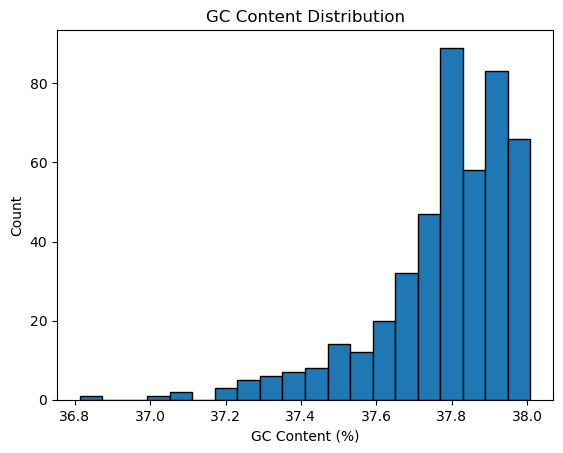

In [16]:
# Plot GC content distribution
plt.hist(gc_values, bins=20, edgecolor="black")
plt.title("GC Content Distribution")
plt.xlabel("GC Content (%)")
plt.ylabel("Count")
plt.show()

In [17]:
# Filter sequences within the expected GC range (e.g., 37% - 39%)
MIN_GC = 37
MAX_GC = 39
 
filtered_gc = [
    record for record, gc in zip(cleaned_sequences, gc_values) if MIN_GC <= gc <= MAX_GC
]
print(f"Sequences after GC content filtering: {len(filtered_gc)}")

Sequences after GC content filtering: 453


## 5. Nucleotide Frequency Heatmap

The sequences in your `filtered_gc list` are of different lengths. When creating the `np.array`, NumPy expects all sequences to have the same length to form a 2D array, but they don’t, leading to an "inhomogeneous shape" error. To fix this, we can handle the sequences in one of the following ways:

1. __Solution 1 (Padding)__ is suitable if you want to align all sequences for visualiSation and retain information about sequence lengths.
2. __Solution 2 (Truncation)__ works if retaining some but not all data from longer sequences is acceptable.
3. __Solution 3 (Filtering)__ is appropriate if uniform sequence length is critical for downstream analysis.

In [21]:
import numpy as np

# Solution 1: Pad Sequences to Equal Length
# Pad shorter sequences with a placeholder (e.g., "-") to make all sequences the same length.

# Find the maximum length of the sequences
max_length = max(len(record.seq) for record in filtered_gc)

# Pad sequences with "-" to make them the same length
padded_sequences = [
    str(record.seq).ljust(max_length, "-") for record in filtered_gc
]

# Convert to a NumPy array
sequence_matrix = np.array([list(seq) for seq in padded_sequences])
print(sequence_matrix.shape)  # Should now be (number_of_sequences, max_length)

(453, 29903)


In [19]:
import numpy as np

# Solution 2: Truncate Longer Sequences
# If there’s a standard length you want to enforce, truncate sequences longer than this length.

# Define the desired length
desired_length = 29000  # For example, 29,000 bases

# Truncate sequences longer than the desired length
trimmed_sequences = [
    str(record.seq)[:desired_length] for record in filtered_gc if len(record.seq) >= desired_length
]

# Convert to a NumPy array
sequence_matrix = np.array([list(seq) for seq in trimmed_sequences])
print(sequence_matrix.shape)

(453, 29000)


In [20]:
import numpy as np

# Solution 3: Exclude Sequences of Different Lengths
# Keep only sequences with a specific length.

# Filter sequences to include only those of the desired length
desired_length = 29000
filtered_sequences = [
    record for record in filtered_gc if len(record.seq) == desired_length
]

# Convert to a NumPy array
sequence_matrix = np.array([list(str(record.seq)) for record in filtered_sequences])
print(sequence_matrix.shape)


(0,)


Once the sequences are padded, trimmed, or filtered, you can calculate the nucleotide frequencies and generate the heatmap.

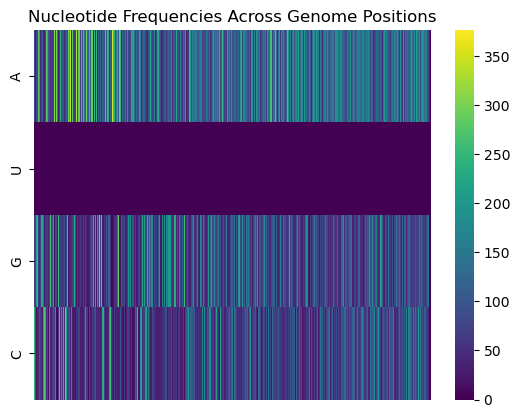

In [22]:
import seaborn as sns

# Calculate nucleotide frequencies at each position
nucleotide_counts = {
    "A": (sequence_matrix == "A").sum(axis=0),
    "U": (sequence_matrix == "U").sum(axis=0),
    "G": (sequence_matrix == "G").sum(axis=0),
    "C": (sequence_matrix == "C").sum(axis=0),
}

# Create heatmap
sns.heatmap(
    np.array(list(nucleotide_counts.values())),
    cmap="viridis",
    xticklabels=False,
    yticklabels=["A", "U", "G", "C"]
)
plt.title("Nucleotide Frequencies Across Genome Positions")
plt.show()

In [ ]:
nucleotide_counts = {
    "A": (sequence_matrix == "A").sum(axis=0),
    "U": (sequence_matrix == "U").sum(axis=0),
    "G": (sequence_matrix == "G").sum(axis=0),
    "C": (sequence_matrix == "C").sum(axis=0),
}

# Create heatmap
sns.heatmap(
    np.array(list(nucleotide_counts.values())),
    cmap="viridis",
    xticklabels=False,
    yticklabels=["A", "U", "G", "C"]
)
plt.title("Nucleotide Frequencies Across Genome Positions")
plt.show()


## 6. Save Processed Data

### Save to FASTA File

In [ ]:
processed_file = os.path.join(PROCESSED_DATA_DIR, "cleaned_sequences.fasta")
SeqIO.write(valid_sequences, processed_file, "fasta")
print(f"Processed sequences saved to: {processed_file}")